# Calculate how much production and zooplankton biomass is below 100m

In [27]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import cftime
import matplotlib.colors as colors
import utils

In [28]:
ds_fosi_seas = xr.Dataset()

In [29]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

In [30]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.001'
obs_dir = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1/'

###  grab desired variables

In [31]:
variables = ['photoC_TOT_zint','photoC_TOT_zint_100m',
             'photoC_diat_zint','photoC_diat_zint_100m',
             'mesozooC','microzooC',]

In [32]:
ds = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_fosi = xr.open_dataset(obs_dir + case + '.pop.h.' + var + '.024501-030512.nc')
    
    ds = xr.merge([ds, ds_fosi])

starting on  photoC_TOT_zint
starting on  photoC_TOT_zint_100m
starting on  photoC_diat_zint
starting on  photoC_diat_zint_100m
starting on  mesozooC
starting on  microzooC


### Do a few depth integrals

In [37]:
ds['mesozooC_zint'] = (ds.mesozooC * 10.).sum(dim='z_t_150m')
ds['mesozooC_zint_100m'] = (ds.mesozooC.isel(z_t_150m=slice(0,10)) * 10.).sum(dim='z_t_150m')
ds.mesozooC_zint.attrs['units'] = 'mmol m$^{-2}$'
ds.mesozooC_zint_100m.attrs['units'] = 'mmol m$^{-2}$'

In [38]:
ds['microzooC_zint'] = (ds.microzooC * 10.).sum(dim='z_t_150m')
ds['microzooC_zint_100m'] = (ds.microzooC.isel(z_t_150m=slice(0,10)) * 10.).sum(dim='z_t_150m')
ds.microzooC_zint.attrs['units'] = 'mmol m$^{-2}$'
ds.microzooC_zint_100m.attrs['units'] = 'mmol m$^{-2}$'

### Make a mean over the whole IAF cycle

In [39]:
ds_mean = ds.mean(dim='time')

### Make some quick maps of percent NPP, biomass below 100m

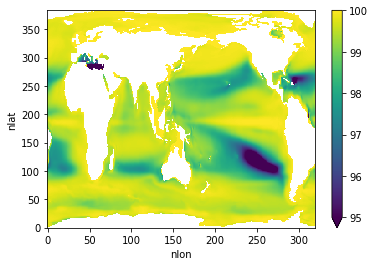

In [66]:
NPP_100m_percent = ds_mean.photoC_TOT_zint_100m/ds_mean.photoC_TOT_zint * 100.
NPP_100m_percent.plot(vmin=95,vmax=100)

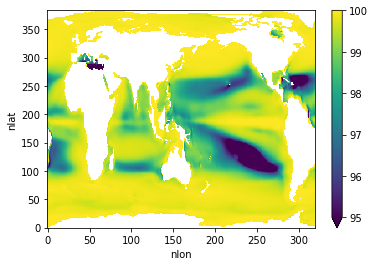

In [67]:
diatNPP_100m_percent = ds_mean.photoC_diat_zint_100m/ds_mean.photoC_diat_zint * 100.
diatNPP_100m_percent.plot(vmin=95,vmax=100)

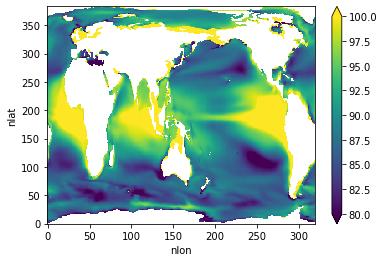

In [70]:
mesozooC_100m_percent = ds_mean.mesozooC_zint_100m/ds_mean.mesozooC_zint * 100.
mesozooC_100m_percent.plot(vmin=80,vmax=100)

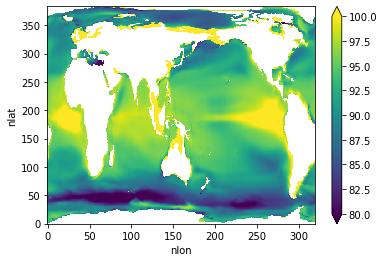

In [71]:
microzooC_100m_percent = ds_mean.microzooC_zint_100m/ds_mean.microzooC_zint * 100.
microzooC_100m_percent.plot(vmin=80,vmax=100)

### get grid coords and make some nice maps

In [90]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m = area * 1.e-4
depths=ds_grid.z_t * 0.01

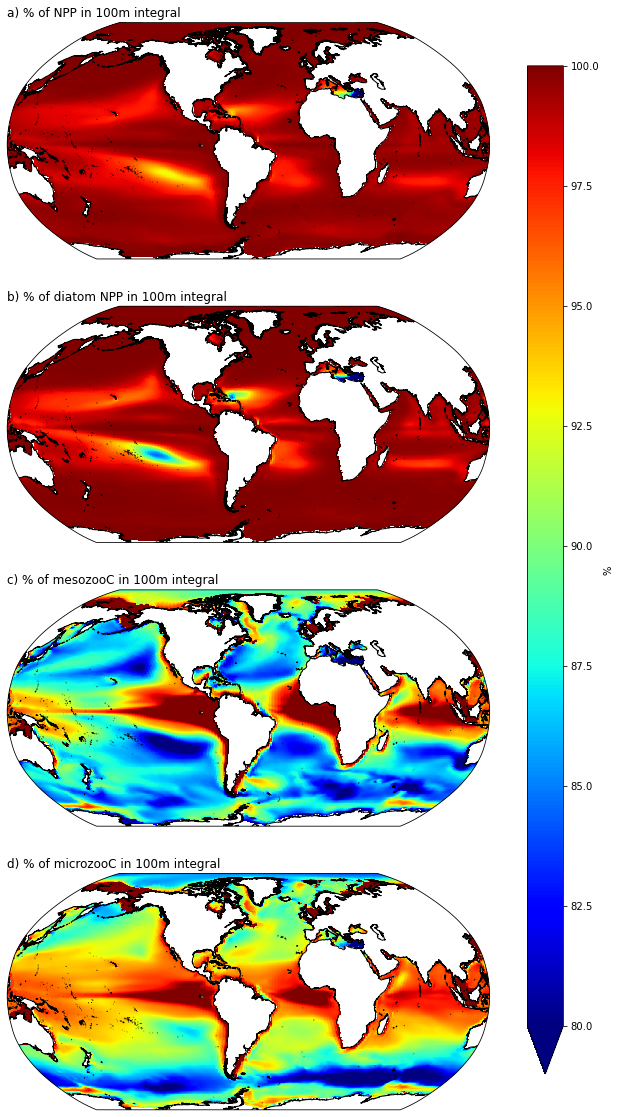

In [85]:
fig = plt.figure(figsize=(10,20))

############### 
ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) % of NPP in 100m integral', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, NPP_100m_percent)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=80,vmax=100)

ax.coastlines('10m',linewidth=1)


############### 
ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) % of diatom NPP in 100m integral', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, diatNPP_100m_percent)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=80,vmax=100)

ax.coastlines('10m',linewidth=1)

############### 
ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) % of mesozooC in 100m integral', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, mesozooC_100m_percent)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=80,vmax=100)

ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='max', label='%');

############### 
ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) % of microzooC in 100m integral', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, microzooC_100m_percent)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='jet',vmin=80,vmax=100)

ax.coastlines('10m',linewidth=1)
#fig.colorbar(pc,extend='max', label='%');

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax, extend='min',label='%');

### Global integrals

In [79]:
import utils

In [80]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

ds_glb = xr.Dataset()

variables =  ['photoC_TOT_zint','photoC_TOT_zint_100m','photoC_diat_zint','photoC_diat_zint_100m']
    
ds_glb = utils.global_integral(ds_mean, ds_grid, variables, include_ms=False)


for v in variables:
    
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb

<xarray.Dataset>
Dimensions:                ()
Data variables:
    photoC_TOT_zint        float64 52.23
    photoC_TOT_zint_100m   float64 51.86
    photoC_diat_zint       float64 20.71
    photoC_diat_zint_100m  float64 20.62

In [81]:
microzoo_biomass = (ds_mean.microzooC_zint * area_m).sum(dim=('nlon','nlat'))
ds_glb['microzooC_zint'] = microzoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

mesozoo_biomass = (ds_mean.mesozooC_zint * area_m).sum(dim=('nlon','nlat'))
ds_glb['mesozooC_zint'] = mesozoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

microzoo_biomass = (ds_mean.microzooC_zint_100m * area_m).sum(dim=('nlon','nlat'))
ds_glb['microzooC_zint_100m'] = microzoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C

mesozoo_biomass = (ds_mean.mesozooC_zint_100m * area_m).sum(dim=('nlon','nlat'))
ds_glb['mesozooC_zint_100m'] = mesozoo_biomass.values * 0.001 * 1.e-15 * 12.011 #Pg C


ds_glb

<xarray.Dataset>
Dimensions:                ()
Data variables:
    photoC_TOT_zint        float64 52.23
    photoC_TOT_zint_100m   float64 51.86
    photoC_diat_zint       float64 20.71
    photoC_diat_zint_100m  float64 20.62
    microzooC_zint         float64 0.2294
    mesozooC_zint          float64 0.3993
    microzooC_zint_100m    float64 0.213
    mesozooC_zint_100m     float64 0.3592

In [82]:
print('The upper 100m contains ', ds_glb.photoC_TOT_zint_100m.values/ds_glb.photoC_TOT_zint.values * 100, '% of NPP')
print('The upper 100m contains ', ds_glb.photoC_diat_zint_100m.values/ds_glb.photoC_diat_zint.values * 100, '% of diatom NPP')

The upper 100m contains  99.29589328937642 % of NPP
The upper 100m contains  99.5767867446229 % of diatom NPP


In [83]:
print('The upper 100m contains ', ds_glb.mesozooC_zint_100m.values/ds_glb.mesozooC_zint.values * 100, '% of mesozooplankton biomass')
print('The upper 100m contains ', ds_glb.microzooC_zint_100m.values/ds_glb.microzooC_zint.values * 100, '% of microzooplankton biomass')

The upper 100m contains  89.9522441886625 % of mesozooplankton biomass
The upper 100m contains  92.83497785264018 % of microzooplankton biomass


### Make profiles over the top 150m

In [87]:
microzoo_biomass = (ds_mean.microzooC * area_m).sum(dim=('nlon','nlat'))
ds_glb['microzooC'] = microzoo_biomass.values * 0.001 * 1.e-12 * 12.011 #Tg C

mesozoo_biomass = (ds_mean.mesozooC * area_m).sum(dim=('nlon','nlat'))
ds_glb['mesozooC'] = mesozoo_biomass.values * 0.001 * 1.e-12 * 12.011 #Tg C

In [88]:
ds_glb['microzooC']

<xarray.DataArray 'microzooC' (microzooC: 15)>
array([2.938444, 2.930393, 2.879902, 2.71442 , 2.506036, 2.211283, 1.843232,
       1.439334, 1.063534, 0.771241, 0.568111, 0.420863, 0.304542, 0.21173 ,
       0.138524])
Coordinates:
  * microzooC  (microzooC) float64 2.938 2.93 2.88 ... 0.3045 0.2117 0.1385

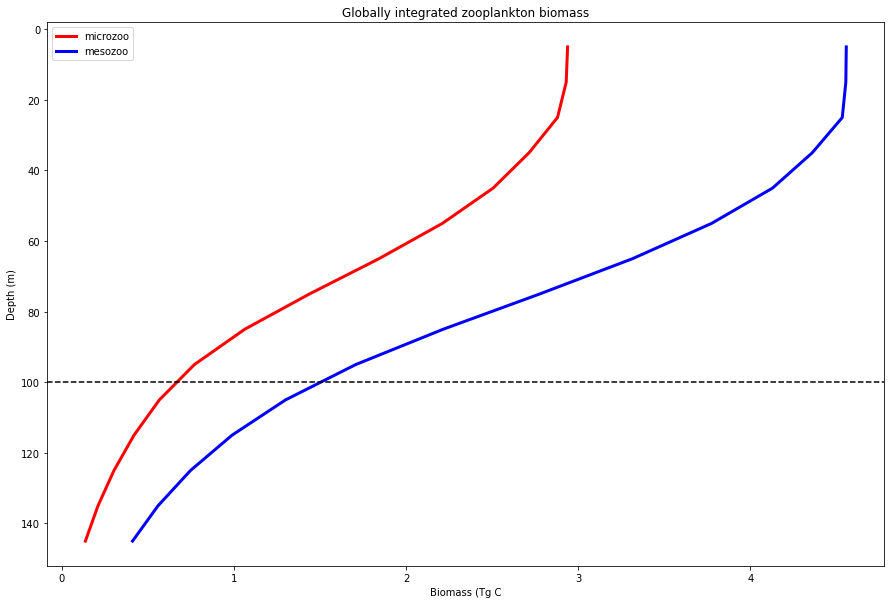

In [97]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated zooplankton biomass')
ax.plot(ds_glb['microzooC'].values, depths.isel(z_t=slice(0,15)), label='microzoo', linewidth=3, color='red')
ax.plot(ds_glb['mesozooC'].values, depths.isel(z_t=slice(0,15)), label='mesozoo', linewidth=3, color='blue')
ax.legend()
ax.set(ylabel='Depth (m)',xlabel='Biomass (Tg C')
ax.axhline(100, color='black',linestyle='--')
plt.gca().invert_yaxis()

